# Santacoder using FastAPI
______________________________

## Introduction
______________________________

In this tutorial, we're going to do a walk through of how we created and deployed an API for the [Santacoder LLM model](https://huggingface.co/bigcode/santacoder) with BlindBox. The Santacoder model performs code generation. When given the start of a code block, it will autocomplete the rest of the code. By deploying Santacoder with BlindBox, developers working with private code bases can be sure the code they send to the model is kept confidential at all times and is not exposed to the service provider. 

Preparing and deploying an application with BlindBox can be broken down into four stages:

[IMAGE HERE]

In this tutorial, we are primarily going to focus on the first step: Preparing the application image.

We will split this into two sub-steps:

1. How we **created a BlindBox-compatible API** for the model.
2. How we **created the Docker image** for our API.

Once we have covered this step, we will provide a quick demonstration of how to deploy and query the application image.

> You can learn about how we deploy images with BlindBox in more detail in the [Quick tour](https://blindbox.mithrilsecurity.io/en/latest/docs/getting-started/quick-tour/).

Let's dive in!

## Pre-requisites
____________________

To follow along with this tutorial, you will need to:

+ Have Docker installed in your environment. Here's the [Docker installation guide](https://docs.docker.com/desktop/install/linux-install/).
+ Have [blindbox](https://pypi.org/project/blindbox/), [terraform](https://www.terraform.io/) and the [Azure CLI tool](https://learn.microsoft.com/en-us/cli/azure/install-azure-cli) installed.

In [ ]:
# install blindbox & blindbox CLI
!pip install blindbox[cli]

# Download terraform
!wget -O- https://apt.releases.hashicorp.com/gpg | sudo gpg --dearmor -o /usr/share/keyrings/hashicorp-archive-keyring.gpg

# Add terraform to trusted apt packages
!echo "deb [signed-by=/usr/share/keyrings/hashicorp-archive-keyring.gpg] https://apt.releases.hashicorp.com $(lsb_release -cs) main" | sudo tee /etc/apt/sources.list.d/hashicorp.list

# Install terraform
!sudo apt update && sudo apt install terraform

# Install azure-cli
!curl -sL https://aka.ms/InstallAzureCLIDeb | sudo bash

## Packaging Santacoder with FastAPI
_______________________

Our first task in deploying the **Santacoder** model inside of a secure **BlindBox** was to create an API so that our end users would be able to query the model. We did this using the **FastAPI library** which allows us to quickly assign functions to API endpoints.
 
The full code we use to do this is available in the `server.py` file in the `examples/santacoder` folder in BlindBox's official GitHub repository.

In [ ]:
!git clone https://github.com/mithril-security/blindbox
!cd examples/santacoder

There are three key sections in this code:

### Initial set-up

Firstly, we load the santacoder model from Hugging Face, and initialize our API.

```python
model_name = "bigcode/santacoder"

# get tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

device = "cpu" # cuda for GPU usage or cpu for CPU usage

# get model and call eval
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True).to(device).eval()

# instantiate API object
app = FastAPI()
```

### Creating an endpoint

Secondly, we create a `/generate` POST endpoint on our FastAPI application object. The user will be able to send their initial code to this endpoint and get back the model's full generated code block.

```python
# define GenerateRequest input object
class GenerateRequest(BaseModel):
    input_text: str
    max_new_tokens: int = 128

@app.post("/generate")
def generate(req: GenerateRequest):

    # We go from string to token lists
    inputs = tokenizer.encode(req.input_text, return_tensors="pt").to(device)
    
    # query model with inputs
    outputs = model.generate(inputs)
    
    # Convert tokens back to a string
    text = tokenizer.decode(outputs[0])

    return {"text": text}
```

### Launching our server

Finally, we deploys our API on a python ASGI `uvicorn` server (an asynchronous web server) on `port 80`. It is essential to use **port 80** as BlindBox will need to be able to communicate with our application on this port!

```python
if __name__ == "__main__":
    uvicorn.run(app, host="0.0.0.0", port=80)
```

To sum up, we packaged the Santacoder model as an API by doing the following:

+ Creating an API app object that "configures" the `uvicorn` server by providing handlers for specific endpoints

+ Creating a `generate` endpoint which in turn queries the santacoder model.

+ Deploying our API on our server on `port 80`.

## Packaging our application in a Docker image
________________________________

Once we had created out Santacoder API, all that was left to do was create a **Docker image** for our application that could then be deployed with BlindBox. Let's take a look at the Dockerfile we used to do this:

```docker
FROM python:3.10.10-bullseye as base

# install dependencies
RUN pip install \
    torch==1.13.1 \
    transformers==4.26.1 \
    fastapi==0.95.0 \
    python-multipart==0.0.6 \
    uvicorn==0.21.1 \
    pydantic==1.10.7 \
    intel_extension_for_pytorch==1.13.100 \
    --extra-index-url https://download.pytorch.org/whl/cpu

# copy our app code to container
COPY ./server.py ./

# signal that our application runs on port 80
EXPOSE 80

# run our app server
CMD python ./server.py
```

> Same as for the application code, this file can be viewed in the `examples/santacoder` folder on the official BlindBox GitHub repository.

There are no complex requirements for the Docker image, but it is recommended to `EXPOSE` port 80 to signal that the application will be running on port 80 within our BlindBox.

### Deploying our application

We explain how to get everything set-up in order to deploy applications with BlindBox in more detail our [Quick Tour](../../docs/docs/getting-started/quick-tour.ipynb).

Here, we will take a brief look at the code we used to deploy our BlindBox on a system which already had all the pre-requisites set-up.

In [ ]:
# download and navigate to santacoder folder
!git clone https://github.com/mithril-security/blindbox
!cd examples/santacoder

In [ ]:
# initialize the blindbox
!blindbox --platform azure-sev init

# build santacoder application assigning it the tag "myimage"
!docker build -t myimage .

# deploy our image inside Confidential VM using BlindBox
!blindbox deploy myimage-blindbox:v1

> Note that when we launch `blindbox deploy`, we will see details about the Azure resources that will be created by the process and must input 'yes' in order to complete deployment.

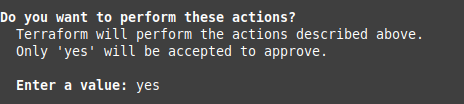

When this process is complete, you will see the following success message.

### Querying our application

We were then able to query our santacoder application within our Confidential BlindBox. The code we send to the application is protected from outside access at every step of its journey!

In [ ]:
# install blindbox
!pip install blindbox

# import requests module
from blindbox  import requests

CONFIDENTIAL_VM_IP_ADDRESS = "127.0.0.1:80" # replace with your VM IP address and port

# we query our application, sending it a snippet of code to be completed by the model
res = requests.post(url=f"http://{CONFIDENTIAL_VM_IP_ADDRESS}/generate", json={"input_text": "def print_hello_world():"})

# display result
print(res.text)

We get back our completed code block generated by the model!

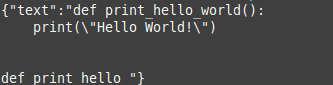

## Conclusions
_______________________
 
In this tutorial, we've seen how we can:
+ Create a **BlindBox-compatible application**
+ Create an **application image**, ready to be built and deployed on BlindBox!

For more details on the deployment process, see our [quick tour](../../docs/docs/quick-tour)